# Kelompok 6

1. Agung Malik Al Qindy
2. M.Nuril Haidar
3. Zhubair Abhel M.

In [1]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-ind tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 5,353 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ind all 1:4.00~git30-7274cfa-1.1 [537 kB]
Fetched 5,353 kB in 2s (3,073 kB/s)
debconf: unable to ini

In [2]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
import re
import sys
import json
from datetime import datetime

In [ ]:
class KTPInformation(object):
    def __init__(self):
        self.nik = ""
        self.nama = ""
        self.tempat_lahir = ""
        self.tanggal_lahir = ""
        self.jenis_kelamin = ""
        self.golongan_darah = ""
        self.alamat = ""
        self.rt = ""
        self.rw = ""
        self.kelurahan_atau_desa = ""
        self.kecamatan = ""
        self.agama = ""
        self.status_perkawinan = ""
        self.pekerjaan = ""
        self.kewarganegaraan = ""
        self.berlaku_hingga = ""

In [ ]:
class KTPOCR(object):
    def __init__(self, image):
        self.image = cv2.imread(image)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.th, self.threshed = cv2.threshold(self.gray, 127, 255, cv2.THRESH_TRUNC)
        self.result = KTPInformation()
        self.master_process()

    def process(self, image):
        raw_extracted_text = pytesseract.image_to_string((self.threshed), lang="ind")
        return raw_extracted_text

    def word_to_number_converter(self, word):
        word_dict = {
            '|' : "1"
        }
        res = ""
        for letter in word:
            if letter in word_dict:
                res += word_dict[letter]
            else:
                res += letter
        return res


    def nik_extract(self, word):
        word_dict = {
            'b' : "6",
            'e' : "2",
        }
        res = ""
        for letter in word:
            if letter in word_dict:
                res += word_dict[letter]
            else:
                res += letter
        return res

    def extract(self, extracted_result):
        #print(extracted_result.replace('\n', ' -- '))
        for word in extracted_result.split("\n"):
            if "NIK" in word:
                word = word.split(':')
                self.result.nik = self.nik_extract(word[-1].replace(" ", ""))
                continue

            if "Nama" in word:
                word = word.split(':')
                self.result.nama = word[-1].replace('Nama ','')
                continue

            if "Tempat" in word:
                word = word.split(':')
                self.result.tanggal_lahir = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", word[-1])[0]
                self.result.tempat_lahir = word[-1].replace(self.result.tanggal_lahir, '')
                continue

            if 'Darah' in word:
                self.result.jenis_kelamin = re.search("(LAKI-LAKI|LAKI|LELAKI|PEREMPUAN)", word)[0]
                word = word.split(':')
                try:
                    self.result.golongan_darah = re.search("(O|A|B|AB)", word[-1])[0]
                except:
                    self.result.golongan_darah = '-'
            if 'Alamat' in word:
                self.result.alamat = self.word_to_number_converter(word).replace("Alamat ","")
            if 'NO.' in word:
                self.result.alamat = self.result.alamat + ' '+word
            if "Kecamatan" in word:
                self.result.kecamatan = word.split(':')[1].strip()
            if "Desa" in word:
                wrd = word.split()
                desa = []
                for wr in wrd:
                    if not 'desa' in wr.lower():
                        desa.append(wr)
                self.result.kelurahan_atau_desa = ''.join(wr)
            if 'Kewarganegaraan' in word:
                self.result.kewarganegaraan = word.split(':')[1].strip()
            if 'Pekerjaan' in word:
                wrod = word.split()
                pekerjaan = []
                for wr in wrod:
                    if not '-' in wr:
                        pekerjaan.append(wr)
                self.result.pekerjaan = ' '.join(pekerjaan).replace('Pekerjaan', '').strip()
            if 'Agama' in word:
                self.result.agama = word.replace('Agama',"").strip()
            if 'Perkawinan' in word:
                self.result.status_perkawinan = word.split(':')[1]
            if "RTRW" in word:
                word = word.replace("RTRW",'')
                self.result.rt = word.split('/')[0].strip()
                self.result.rw = word.split('/')[1].strip()

    def master_process(self):
        raw_text = self.process(self.image)
        self.extract(raw_text)

    def to_json(self):
        return json.dumps(self.result.__dict__, indent=4)

In [ ]:
def read(ktp_path):
    img = cv2.imread(ktp_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## (2) Threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)

    ## (3) Detect
    result = pytesseract.image_to_string((threshed), lang="ind")

    final = []

    ## (5) Normalize
    for word in result.split("\n"):
        if "”—" in word:
            word = word.replace("”—", ":")

        #normalize NIK
        if "NIK" in word:
            nik_char = word.split()
        #if "D" in word:
        #    word = word.replace("D", "0")
        if "?" in word:
            word = word.replace("?", "7")

        final.append(word)
    return final

if __name__ == "__main__":
      path = '/content/drive/MyDrive/Colab Notebooks/Machine Learning/KTP_ML/KTP_14.jpg'
      cv2_imshow(cv2.imread(path))
      ocr = KTPOCR(path)
      word = ocr.to_json()
      print(word)

Output hidden; open in https://colab.research.google.com to view.

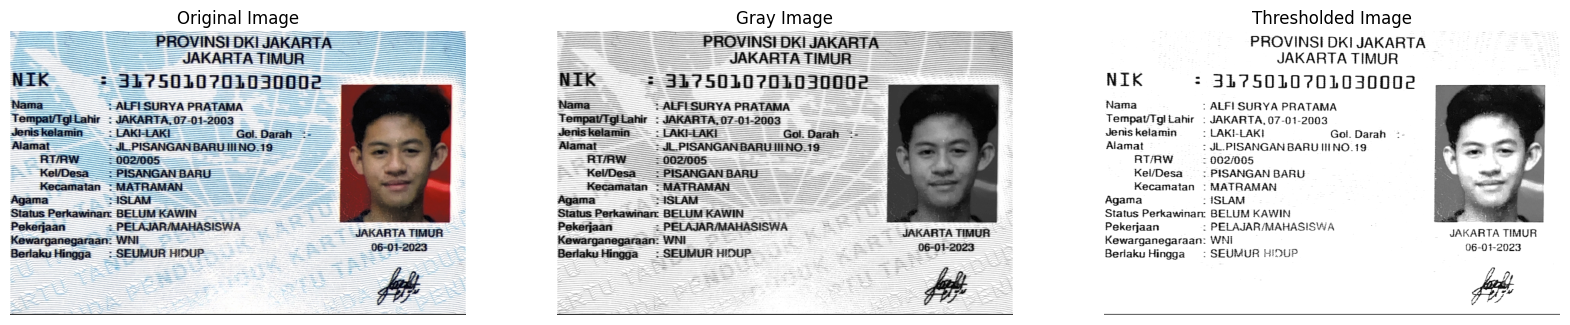

PROVINSI DKI JAKARTA
JAKARTA TIMUR

NIK 3 3105010701030002
Nama : ALFI SURYA PRATAMA
Tempat/Tgi Lahir : JAKARTA, 07-01-2003
Jenis kelamin 1 LAKI-LAKI Gol. Darah
Alamat 1 JL PISANGAN BARU III NO.19

RT/RW 1 002/005

Kel/Desa 1 PISANGAN BARU
Kecamatan : MATRAMAN

   

Agama : ISLAM
Status Perkawinan: BELUM KAWIN "2
Pekerjaan 1 PELAJAR/MAHASISWA JAKARTA TIMUR

Kewarganegaraan: WNI

-01-2023
Berlaku Hingga — : SEUMUR HIDUP 06

ph

 



In [11]:
import random
import os

directory = "/content/drive/MyDrive/Colab Notebooks/Machine Learning/KTP_ML"

image_files = [file for file in os.listdir(directory) if file.endswith((".jpg", ".jpeg", ".png", ".JPG"))]

selected_images = random.sample(image_files, 1)

for image_file in selected_images:
  image_path = os.path.join(directory, image_file)
  img = cv2.imread(image_path)

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)

  fig, ax = plt.subplots(1, 3, figsize=(20, 6))

  ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[0].set_title('Original Image')
  ax[0].axis('off')

  ax[1].imshow(gray, cmap='gray')
  ax[1].set_title('Gray Image')
  ax[1].axis('off')

  ax[2].imshow(threshed, cmap='gray')
  ax[2].set_title('Thresholded Image')
  ax[2].axis('off')

  plt.show()

  text = pytesseract.image_to_string(threshed, lang="ind")
  print(text)